In [1]:
from panel_segmentation.lidar import pcd_data, plane_segmentation
from panel_segmentation import utils
from shapely.wkt import loads
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
import numpy as np
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Estimating Solar Panel's Tilt and Azimuth through LiDAR

Calculating a solar panel's tilt and azimuth is often a manual process and the process can be tedious, especially when looking at hundreds of solar installations. This Juypter notebook example shows an automated process in estimating a solar panel's tilt and azimuth through LiDAR.

Light Detection and Ranging (LiDAR) is a remote sensing technology that uses light pulses, usually from lasers, to collect 3D coordinate points of terrains and buildings. These 3D x, y, z coordinate points are called point cloud data (PCD). LiDAR files are saved as .laz or .las files and can contain millions of point cloud data. LiDAR is often used in a geographical setting to create high-resolution maps of terrains, buildings, and other environmental objects. More information of LiDAR can be found on the [USGS website](https://www.usgs.gov/faqs/what-lidar-data-and-where-can-i-download-it).

The United States Geological Survery (USGS) provides free LiDAR data that covers most regions throughout the US. These data can be found through their [LiDAR Explorer page](https://apps.nationalmap.gov/lidar-explorer/#/) or through their [online database](https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/). This example specifically uses USGS data. 

The process for estimating the tilt and azimuth through LiDAR can be broken down into 5 main steps.
<br>1) Generate a shapely polygon of EPSG:4326 latitude, longitude coordinates that outlines the solar panel. 
<br>2) Download or provide the associated .laz file containing the shapely polygon.
<br>3) Crop and filter the LiDAR PCD to only include points within the shapely polygon.
<br>4) Generate planes from the filtered PCD and calculate the plane's tilt and azimuth from its normal vectors.
<br>5) Merge similar planes and calculate the tilt and azimuth from the "best" merged plane.



## 1) Generate a Lat, Lon Shapely Polygon

Shapely polygons can be manually provided or automatically generated by making inferences through the panel detection pipeline (see [Austin_hail_damage_example.ipynb](./Austin_hail_damage_example.ipynb) or [Sol-Searcher_example.ipynb](/Sol-Searcher_example.ipynb)). For simplicity, a polygon will be provided for this example.

When providing the shapely polygon, it's important that it lines up correctly with the underlying LiDAR data to correctly select the rooftop that contains the solar panel. Incorrect alignment may result in incorrect rooftop selection when generating the planes and as a consequence, result in incorrect tilt and azimuth estimations. The shapely polygon also needs to be in EPSG:4326 latitude, longitude coordinate system.

In [2]:
# Example shapely polygon of a panel
shapely_polygon = loads("""POLYGON ((-97.7410365895264 30.14785292729047,
-97.74099443156318 30.14784570793002,
-97.740996994135 30.14783129573295,
-97.74096682042823 30.14782630274932,
-97.74096991677864 30.14781279987441,
-97.74106244111351 30.14782773968074,
-97.74105940427461 30.14784167739671,
-97.74103964225441 30.14783807111269,
-97.7410365895264 30.14785292729047))""")

For visualization purposes, the shapely polygon is plotted on top of its satellite image.

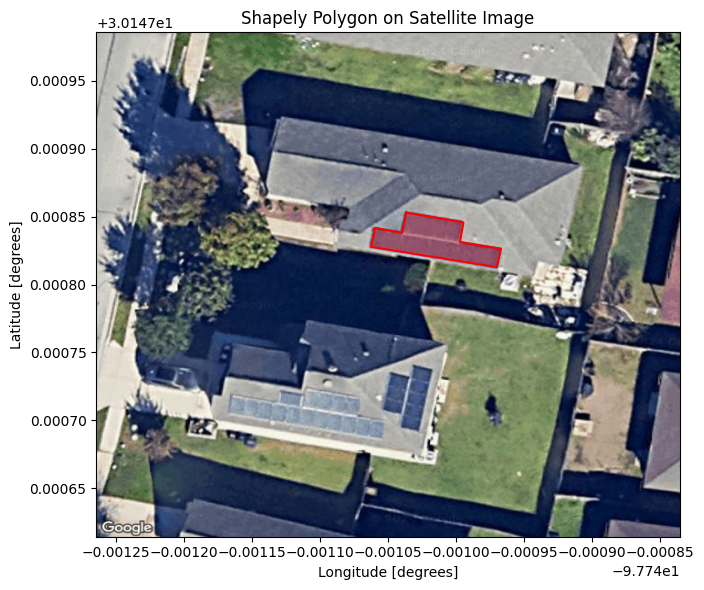

In [3]:
# Satellite image where solar panel is located
satellite_img_path = os.path.join(os.getcwd(), r"panel_segmentation\examples\lidar_examples\30.1478_-97.74105.png") 
# Get the center latitude and longitude associated with the file
center_coords = os.path.basename(satellite_img_path).replace(".png", "").split("_")
center_lat, center_lon = float(center_coords[0]), float(center_coords[1])
# Zoom level of image is 21
zoom_level = 21
# Google maps pixel to meter conversion:
meter_per_pixel_conversion = 156543.03392 * np.cos(np.radians(center_lat)) / (2**zoom_level)

# Get the width and height of the image
img = Image.open(satellite_img_path)
width, height = img.size
# Get width and height in meters
width_meters = width * meter_per_pixel_conversion
height_meters = height * meter_per_pixel_conversion
# Get offset from center to ne, sw corners
sw_corner = (-height_meters/2, -width_meters/2)
ne_corner = (height_meters/2, width_meters/2)
# Convert sw, ne corner meter coordinates into lat, lon using utils.TranslateLatLonCoordinates
sw_lat, sw_lon = utils.translateLatLongCoordinates(center_lat, center_lon, sw_corner[0], sw_corner[1])
ne_lat, ne_lon = utils.translateLatLongCoordinates(center_lat, center_lon, ne_corner[0], ne_corner[1])

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
# Set lat, lon bounds on image
ax.imshow(img, extent=[sw_lon, ne_lon, sw_lat, ne_lat])
# Now plot and fill the shapely polygon 
ax.plot(*shapely_polygon.exterior.xy, color="red")
ax.fill(*shapely_polygon.exterior.xy, color="red", alpha=0.3)
# Set labels and title
ax.set_xlabel("Longitude [degrees]")
ax.set_ylabel("Latitude [degrees]")
ax.set_title("Shapely Polygon on Satellite Image")
plt.tight_layout()
plt.show()

## 2) Get the .laz File that Contains the Shapely Polygon

All USGS LiDAR dataset is pulled via a custom [USGS LiDAR API](./panel_segmentation/lidar/usgs_lidar_api.py) within the panel segmentation package. Using this API, the [master_usgs_lidar_dataset_names.parquet](./panel_segmentation/lidar/data/master_usgs_lidar_dataset_names.parquet) and [master_usgs_lidar_metadata.parquet](./panel_segmentation/lidar/data/master_usgs_lidar_metadata.parquet) are generated and saved in memory within the [data](./panel_segmentation/lidar/data/) folder. master_usgs_lidar_dataset_names.parquet contains all the LiDAR dataset project names found within the [USGS Projects page](https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/) on their online database. master_usgs_lidar_dataset_names.parquet contains columns "dataset_name" and "deprecated_scans", which flags whether the LiDAR data is an old, deprecated scan. master_usgs_lidar_metadata.parquet contains the metadata information associated with each .laz file, including its download link and scan boundaries pulled for the dataset names in master_usgs_lidar_dataset_names.parquet. It has columns "dataset_name", "xml_link", "laz_link", "bbox_west", "bbox_east", "bbox_north", "bbox_south", "start_scan_date", and "end_scan_date" columns.

Using master_usgs_lidar_metadata.parquet, we can get the latest .laz file associated with the shapely polygon. This is done by getting a latitude, longitude coordinate within the polygon and checking if the coordinate is within the scan boundaries of the LiDAR file. If multiple LiDAR files are found, the most recent .laz file is selected. If no LiDAR files are found, then running the LiDAR pipeline to get tilt and azimuth cannot be done. This process is already written in the locateLazFileByLatLon function in the [USGS LiDAR API](./panel_segmentation/lidar/usgs_lidar_api.py). To execute the function, read in the master_usgs_lidar_metadata.parquet file as a Pandas dataframe and provide a latitude, longitude coordinate within the polygon. This function locates the downloadable URL and downloads the .laz file in the defaulted ./data/lidar_laz output folder. An example of running this function can be found below.

```python
    from panel_segmentation.lidar import usgs_lidar_api
    # Initialize the USGSLidarAPI class
    lidar_api = usgs_lidar_api.USGSLidarAPI()
    # Read in the master metadata parquet file
    metadata_df = pd.read_parquet("./data/master_usgs_lidar_dataset_names.parquet")
    # A latitude, longitude coordinate within the polygon
    lat, lon = 30.147832489721004, -97.74102015878317
    # Locate and download the .laz file
    lidar_api.locateLazFileByLatLon(metadata_df, lat, lon)
```


For simplicity, a .laz file is already pulled for the example and cropped to a smaller file size.

In [4]:
# Get.laz file that contains the shapely polygon coordinates
laz_file_path = os.path.join(
    os.getcwd(),
    r"panel_segmentation\examples\lidar_examples\cropped_USGS_LPC_TX_Central_B1_2017_stratmap17_50cm_3097513c1_LAS_2019.laz")

## 3) Crop and Filter LiDAR Point CLoud Data

.laz files are large and can contain millions of point cloud data. From these .laz file, we only need to get the rooftop surfaces where the solar panels are located. This is can done by using the shapely polygon and cropping the LiDAR PCD to only contain points inside that polygon.

In [5]:
# Initialize pcd class
pcd = pcd_data.PCD(laz_file_path, polygon=shapely_polygon)
# Read, crop, and filter pcd data to only contain the points inside the polygon
filtered_pcd = pcd.readCropLaz()
# Preprocess pcd
preprocessed_pcd = pcd.preprocessPcd(filtered_pcd)

# Metadata associated with the pcd to reference later
source_crs = pcd.source_crs
scales = pcd.scales
offsets = pcd.offsets
transformer = pcd.transformer

For visualization purposes, we can plot the preprocessed pcd and shapely polygon on one plot. 

Visualizing pcd can easily be done with [o3d.visualization.draw_geometries()](https://www.open3d.org/docs/latest/python_api/open3d.visualization.draw_geometries.html) function. However, this opens a new browser with the displayed figure. To keep the figures inline with the Juypter notebook and avoid pop-up browsers, the following example will use matplotlib.pyplot to plot the pcd data and shapely polygon.

Additionally, for the following example plot, we are plotting a 2D polygon in a 3D space. This 2D polygon originally does not have a z component and for simplicity, we can get its z component by averaging the z value of all points. This makes the polygon look flat when in reality, it should have a tilt. Again, this is only for visualization purposes to visualize the preprocessed pcd within the shapely polygon so a tilt is not necessary.

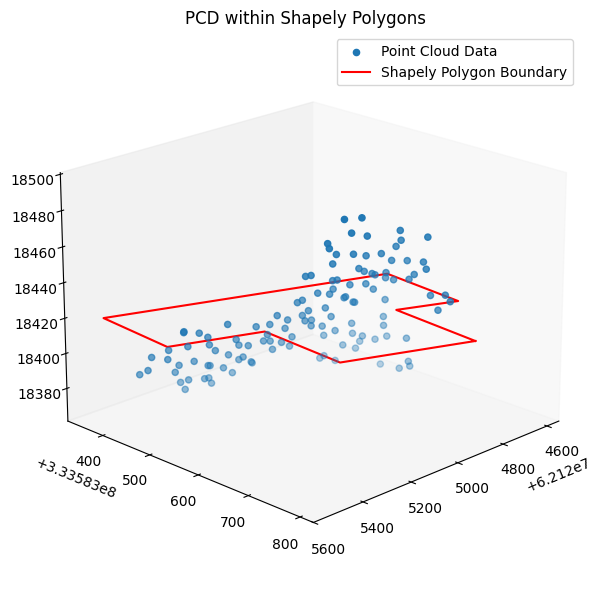

In [6]:
# Visualize preprocessed pcd on a plot
# First, convert open3d pcd to numpy array
points = np.asarray(preprocessed_pcd.points)
# Create a 3d scatter plot with the points
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], label="Point Cloud Data")

# Get shapely polygon and project them ontop of lidar data
transformed_coords = []
for lon, lat in list(shapely_polygon.exterior.coords):
    x, y = transformer.transform(lon, lat)
    x_coord = (x - offsets[0]) / scales[0]
    y_coord = (y - offsets[1]) / scales[1]
    # Get average z coord
    z_coord = np.mean(np.asarray(preprocessed_pcd.points)[:, 2])
    transformed_coords.append([x_coord, y_coord, z_coord])
# Convert to numpy array
transformed_coords = np.array(transformed_coords)
# Plot the polygon line
x_coords = transformed_coords[:, 0]
y_coords = transformed_coords[:, 1]
z_coords = transformed_coords[:, 2]
ax.plot(x_coords, y_coords, z_coords, "r-", label="Shapely Polygon Boundary")

# Remove grid
ax.grid(False)
# Set view for a better look at the pcd
ax.view_init(elev=20, azim=45)
plt.title("PCD within Shapely Polygons")
plt.legend()
plt.tight_layout()
plt.show()

## 4) Generate Planes and Calculate its Tilt and Azimuth

Given a number of 3D points, a plane can be generated from those points. An algorithm to do this is the RANSAC algorithm. More information about how the RANSAC generates plane can be found [here](https://summergeometry.org/sgi2022/plane-and-edge-detection-by-the-random-sample-consensus-ransac-algorithm/). Fortunately, the open3d package already has this implementation and we can call segment_planes function on the point cloud data to get the planes associated with the pcd. For more information about this implementation refer to the Plane Segmentation portion of the [open3d pcd tutorial](https://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html).

From the planes, we can calculate its tilt and azimuth through the plane's normal vectors. The metadata information of each generated plane can be summarized in the following dataframe.

In [7]:
# Initialize PanelSegmentation class with preprocessed pcd
ps = plane_segmentation.PlaneSegmentation(preprocessed_pcd)
# Segment lidar points into planes
ps.segmentPlanes()

# Create a dataframe that summarizes the plane's metadata like tilt and azimuth
all_plane_df = ps.createSummaryPlaneDataframe(source_crs, scales, offsets)
all_plane_df.head(10)


,plane_id,tilt,azimuth,num_points,center_lat,center_lon
0,0,22.541164,189.864908,57,30.147830,-97.741011
1,1,22.511678,189.588774,27,30.147832,-97.741015
2,2,22.510128,189.942565,12,30.147830,-97.741008
3,3,17.701352,270.563701,8,30.147841,-97.741039
4,4,22.394667,190.019352,8,30.147834,-97.741024
5,5,14.102302,222.096869,6,30.147838,-97.741044
6,6,25.543153,195.840633,4,30.147834,-97.741004


For visualization purposes, lets plot the mesh planes with the pcd that generates those planes. Again, visualizing point cloud data and mesh planes can be easily done by calling the [o3d.visualization.draw_geometries()](https://www.open3d.org/docs/latest/python_api/open3d.visualization.draw_geometries.html), but to avoid pop-up browser, matplotlib will be used.

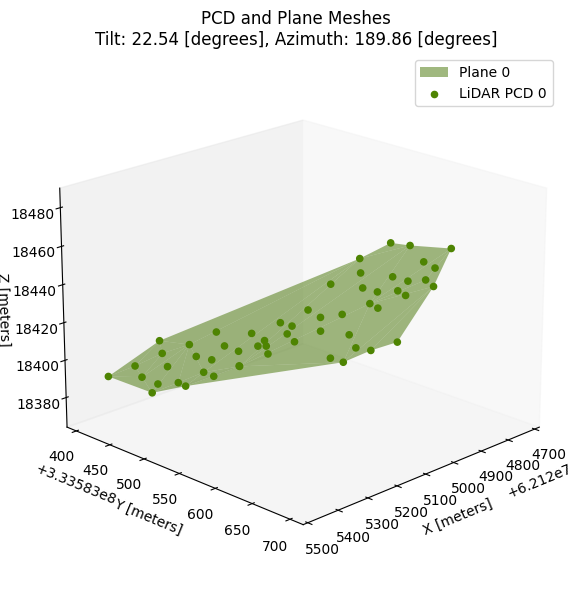

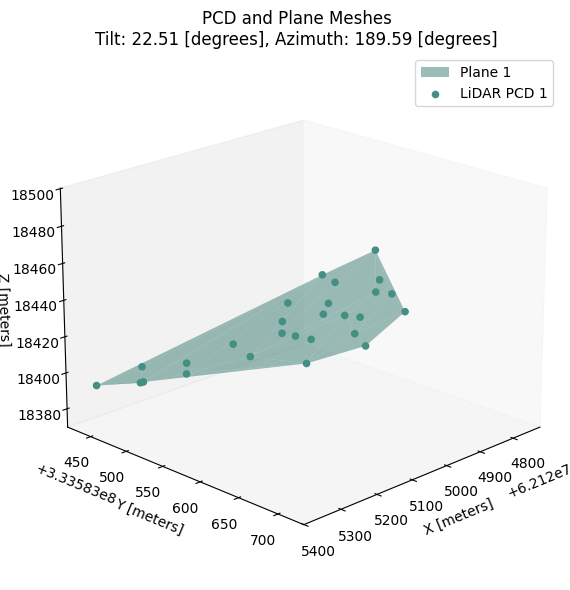

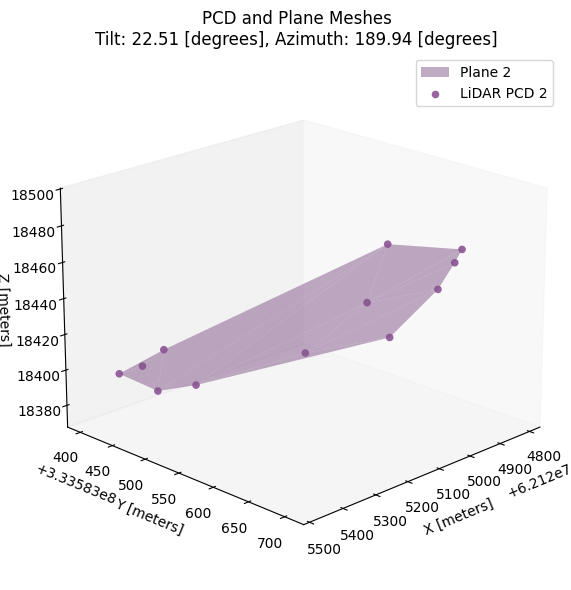

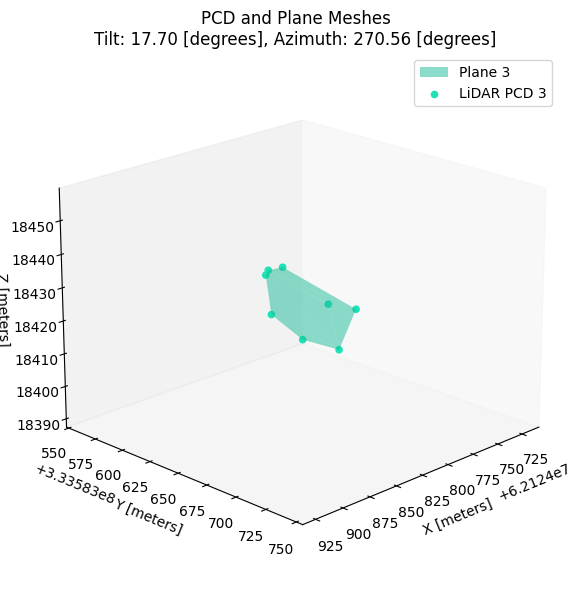

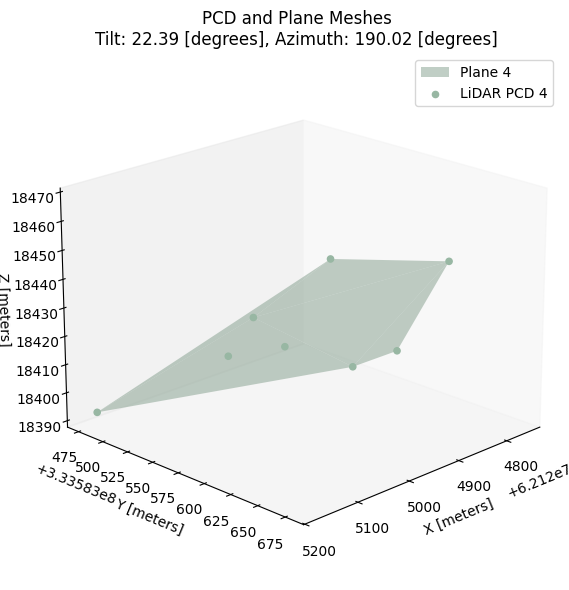

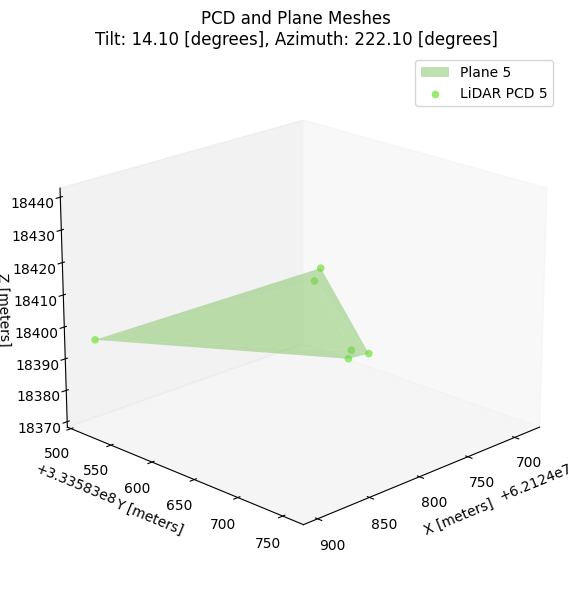

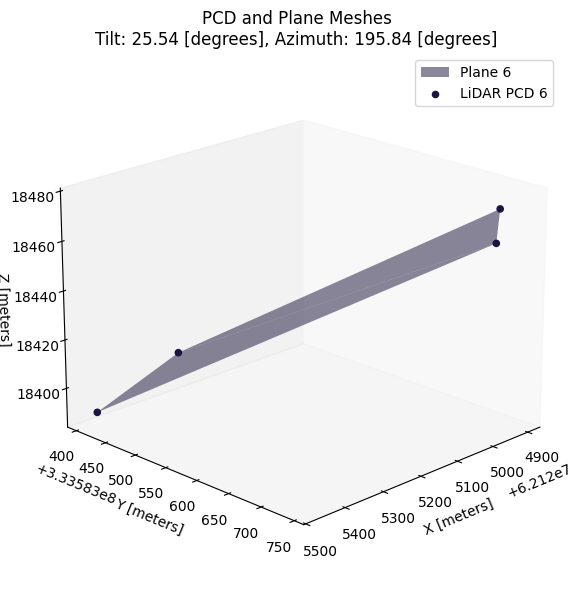

In [8]:
# Create plane mesh for visualization 
pcd_plane_mesh_list = ps.visualizePlanes()

# Iterate through the plane_mesh_list and plot the points/mesh on the same plot
for pcd_dict, tilt, azimuth in zip(pcd_plane_mesh_list, all_plane_df["tilt"], all_plane_df["azimuth"]):
    plane_mesh = pcd_dict["plane_mesh"]
    # Check is a plane was made for the pcd
    # If no plane is made, don't plot it
    if plane_mesh is not None:
        plane_id = pcd_dict["plane_id"]
        pcd = pcd_dict["pcd"]
        color = pcd_dict["color"]
        # Make a new figure for each plane
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")
        # Plot the plane mesh
        vertices = np.asarray(plane_mesh.vertices)
        triangles = np.asarray(plane_mesh.triangles)
        ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                       color=color, label=f"Plane {plane_id}", alpha=0.5)
        # Plot the pcd
        mesh_points = np.asarray(pcd.points)
        ax.scatter(mesh_points[:, 0], mesh_points[:, 1], mesh_points[:, 2],
                   color=color, label=f"LiDAR PCD {plane_id}", alpha=1)

        # Set labels and title
        ax.set_xlabel("X [meters]")
        ax.set_ylabel("Y [meters]")
        ax.set_zlabel("Z [meters]")
        ax.set_title(f"PCD and Plane Meshes\nTilt: {tilt:.2f} [degrees], Azimuth: {azimuth:.2f} [degrees]")
        # Remove grid
        ax.grid(False)
        # Set view for a better look at the pcd
        ax.view_init(elev=20, azim=45)
        ax.legend()
        plt.tight_layout()
        plt.show()

## 5) Merge Similar Planes

The generated planes are often similar and can have tilt and azimuth values that are near each other. If these values are within a 5 degree tilt and 10 degree azimuth threshold, then these planes likely correspond to the same rooftop. We can merge similar planes and get the mean tilt and azimuth of the combined planes.

In [9]:
# Merge similar planes within 5 degree tilt and 10 degree azimuth threshold
ps.mergeSimilarPlanes()
# Make a summary dataframe to display the result
best_plane_df = ps.createSummaryPlaneDataframe(source_crs, scales, offsets)
best_plane_df.head(1)


,plane_id,tilt,azimuth,num_points,center_lat,center_lon
0,0,23.100158,191.051246,108,30.147831,-97.741012


## Comparing Ground Truth Value to LiDAR Estimation

The tilt and azimuth estimation values are close to the ground truth values of the same solar panel. The ground truth value is 24 degree tilt and 187.7 degree azimuth.